# ERA5 Land Soil Water Levels

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = Path("/datadrive/data")
run_dir = data_dir / "runs/complexity_AZURE/hs_064_0306_205514"
out_dir = run_dir / "cell_states"

In [3]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

st_data_dir = Path("/home/tommy/spatio_temporal/data")
points = load_latlon_points(st_data_dir)
static = xr.open_dataset(st_data_dir / "camels_static.nc")

# Input / Target Data

In [4]:
from scripts.cell_state.normalize import normalize_cstate
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable


if not (data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc").exists():
    cn = xr.open_dataset(out_dir / "cell_states.nc")
    norm_cs_data = normalize_cstate(cn, variable_str="c_n")
    norm_cs_data["station_id"] = [int(sid) for sid in norm_cs_data["station_id"]]
    if "date" in norm_cs_data.dims:
        norm_cs_data = norm_cs_data.rename({"date": "time"})

    if isinstance(norm_cs_data, xr.DataArray):
        norm_cs_data = norm_cs_data.to_dataset()

    if "c_n" in [v for v in norm_cs_data.data_vars]:
        norm_cs_data = norm_cs_data.rename({"c_n": "cell_state"})
        
    norm_cs_data.to_netcdf(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")
    
else:
    norm_cs_data = xr.open_dataset(data_dir / "SOIL_MOISTURE/norm_cs_data_FINAL.nc")
 

cs = dataset_dimensions_to_variable(
    ds=norm_cs_data, 
    variable="c_n",
    dimension_to_convert_to_variable_dim="dimension",
)

In [5]:
from scripts.cell_state.normalize import normalize_2d_dataset

filepath = data_dir / "camels_basin_ERA5Land_sm.nc"
era5_ds = xr.open_dataset(filepath)

if not isinstance(era5_ds, xr.Dataset):
    era5_ds = era5_ds.to_dataset()

for var in era5_ds.data_vars:
    era5_ds[var] = normalize_2d_dataset(era5_ds, variable_str=var, per_basin=True)

Normalising each station:   0%|          | 0/670 [00:00<?, ?it/s]/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/extmath.py:709: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs, dtype=np.float64)
Normalising each station:   0%|          | 0/670 [00:00<?, ?it/s]/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/extmath.py:709: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs, dtype=np.float64)
Normalising each station:   0%|          | 0/670 [00:00<?, ?it/s]/home/t

# Train the probes

In [11]:
from scripts.cell_state.sklearn_models import (
    init_linear_model,
    evaluate,
    create_analysis_dataset,
    fit_and_predict,
)
from scripts.cell_state.timeseries_dataset import TimeSeriesDataset, get_time_basin_aligned_dictionary
from collections import defaultdict

In [12]:
target_ds = era5_ds
input_ds = cs

train_start_date: pd.Timestamp = pd.to_datetime("1998-01-01")
train_end_date: pd.Timestamp = pd.to_datetime("2006-09-30")
test_start_date: pd.Timestamp = pd.to_datetime("2006-10-01")
test_end_date: pd.Timestamp =  pd.to_datetime("2009-10-01")
seq_length = 1
basin_dim = "station_id"
time_dim = "time"
input_variables = [f"dim{i}" for i in np.arange(64)]

# train test split
target_data = target_ds.sel(time=slice(train_start_date, train_end_date))
input_data = input_ds.sel(time=slice(train_start_date, train_end_date))

test_target_data = target_ds.sel(time=slice(test_start_date, test_end_date))
test_input_data = input_ds.sel(time=slice(test_start_date, test_end_date))


all_train_test = defaultdict(dict)
for target_var in [v for v in target_data.data_vars if "swvl" in v]:
    print(f"** STARTING {target_var} **")
    train_dataset = TimeSeriesDataset(
        input_data=input_data,
        target_data=target_data,
        target_variable=target_var,
        input_variables=input_variables,
        seq_length=seq_length,
        basin_dim=basin_dim,
        time_dim=time_dim,
        desc="Creating Train Samples",
    )

    train = get_time_basin_aligned_dictionary(train_dataset)

    test_dataset = TimeSeriesDataset(
        input_data=test_input_data,
        target_data=test_target_data,
        target_variable=target_var,
        input_variables=input_variables,
        seq_length=seq_length,
        basin_dim=basin_dim,
        time_dim=time_dim,
        desc="Creating Test Samples",
    )

    test = get_time_basin_aligned_dictionary(test_dataset)
    
    all_train_test[target_var]["train"] = train
    all_train_test[target_var]["test"] = test

** STARTING swvl1 **


Extracting Data: 100%|██████████| 8322/8322 [01:05<00:00, 127.19it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2142/2142 [00:16<00:00, 133.00it/s]


Merging and reshaping arrays
** STARTING swvl2 **


Extracting Data: 100%|██████████| 8322/8322 [01:05<00:00, 127.59it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2142/2142 [00:16<00:00, 130.30it/s]


Merging and reshaping arrays
** STARTING swvl3 **


Extracting Data: 100%|██████████| 8322/8322 [01:03<00:00, 130.27it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2142/2142 [00:16<00:00, 128.26it/s]


Merging and reshaping arrays
** STARTING swvl4 **


Extracting Data: 100%|██████████| 8322/8322 [01:04<00:00, 128.45it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2142/2142 [00:16<00:00, 128.61it/s]

Merging and reshaping arrays


In [15]:
all_train_test.keys()
all_train_test["swvl1"].keys()

dict_keys(['train', 'test'])

# Train and predictions for all models

In [17]:
# initalise the model 
all_models_preds = defaultdict(dict)
target_vars = [v for v in target_data.data_vars if "swvl" in v]

for target_var in [v for v in target_data.data_vars if "swvl" in v]:
    print(f"** {target_var} **")
    model, preds, errors = fit_and_predict(all_train_test[target_var]["train"], all_train_test[target_var]["test"], random_seed=100)
    all_models_preds[target_var]["model"] = model
    all_models_preds[target_var]["preds"] = preds
    all_models_preds[target_var]["errors"] = errors

** swvl1 **
-- Epoch 1
Norm: 0.66, NNZs: 35, Bias: 0.099602, T: 1917358, Avg. loss: 0.025675
Total training time: 1.62 seconds.
-- Epoch 2
Norm: 0.66, NNZs: 36, Bias: 0.101278, T: 3834716, Avg. loss: 0.025646
Total training time: 3.42 seconds.
-- Epoch 3
Norm: 0.66, NNZs: 34, Bias: 0.097082, T: 5752074, Avg. loss: 0.025642
Total training time: 5.22 seconds.
-- Epoch 4
Norm: 0.66, NNZs: 35, Bias: 0.100874, T: 7669432, Avg. loss: 0.025642
Total training time: 7.00 seconds.
Convergence after 4 epochs took 7.17 seconds


Calculating Errors: 100%|██████████| 667/667 [00:08<00:00, 77.88it/s, 106001]


** swvl2 **
-- Epoch 1
Norm: 0.63, NNZs: 35, Bias: -0.062688, T: 1917358, Avg. loss: 0.024680
Total training time: 1.62 seconds.
-- Epoch 2
Norm: 0.63, NNZs: 35, Bias: -0.061131, T: 3834716, Avg. loss: 0.024651
Total training time: 3.39 seconds.
-- Epoch 3
Norm: 0.63, NNZs: 36, Bias: -0.065053, T: 5752074, Avg. loss: 0.024649
Total training time: 5.16 seconds.
-- Epoch 4
Norm: 0.63, NNZs: 34, Bias: -0.061533, T: 7669432, Avg. loss: 0.024648
Total training time: 6.91 seconds.
Convergence after 4 epochs took 7.08 seconds


Calculating Errors: 100%|██████████| 667/667 [00:08<00:00, 77.17it/s, 106001]


** swvl3 **
-- Epoch 1
Norm: 0.71, NNZs: 39, Bias: 0.141131, T: 1917358, Avg. loss: 0.025912
Total training time: 1.57 seconds.
-- Epoch 2
Norm: 0.70, NNZs: 38, Bias: 0.140889, T: 3834716, Avg. loss: 0.025872
Total training time: 3.31 seconds.
-- Epoch 3
Norm: 0.71, NNZs: 38, Bias: 0.141995, T: 5752074, Avg. loss: 0.025869
Total training time: 5.02 seconds.
-- Epoch 4
Norm: 0.71, NNZs: 39, Bias: 0.142236, T: 7669432, Avg. loss: 0.025869
Total training time: 6.74 seconds.
Convergence after 4 epochs took 6.91 seconds


Calculating Errors: 100%|██████████| 667/667 [00:08<00:00, 77.40it/s, 106001]


** swvl4 **
-- Epoch 1
Norm: 0.78, NNZs: 33, Bias: 0.128958, T: 1917358, Avg. loss: 0.031037
Total training time: 1.60 seconds.
-- Epoch 2
Norm: 0.78, NNZs: 35, Bias: 0.130276, T: 3834716, Avg. loss: 0.030986
Total training time: 3.36 seconds.
-- Epoch 3
Norm: 0.79, NNZs: 34, Bias: 0.127694, T: 5752074, Avg. loss: 0.030984
Total training time: 5.14 seconds.
-- Epoch 4
Norm: 0.79, NNZs: 34, Bias: 0.134112, T: 7669432, Avg. loss: 0.030981
Total training time: 6.90 seconds.
Convergence after 4 epochs took 7.07 seconds


Calculating Errors: 100%|██████████| 667/667 [00:08<00:00, 79.17it/s, 106001]


# Explore results

In [ ]:
all_models_preds

### plot timeseries

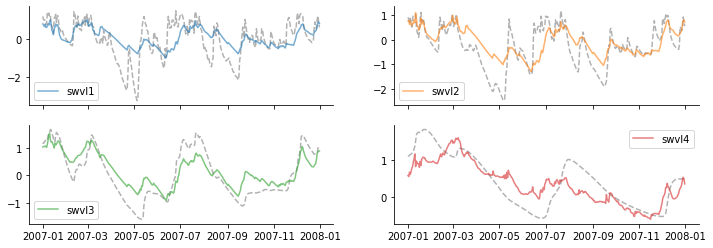

In [27]:
p = all_models_preds["swvl1"]["preds"]
time = "2007"

N = 1
pixels = np.random.choice(p.station_id.values, N, replace=False)

for px in pixels:
    f, axs = plt.subplots(2, 2, figsize=(12, 4), sharex=True)
    for ix, target_var in enumerate(target_vars):
        ax = axs[np.unravel_index(ix, (n_plots, 2))]
        preds = all_models_preds[target_var]["preds"]
        data = preds.sel(station_id=px, time=time)

    #     f, ax = plt.subplots(figsize=(12, 4))
        ax.plot(data.time, data.obs, color="k", ls="--", alpha=0.3)
        ax.plot(data.time, data.sim, color=f"C{ix}", ls="-", alpha=0.6, label=f"{target_var}")
        ax.legend()
        sns.despine()

### plot nse distributions

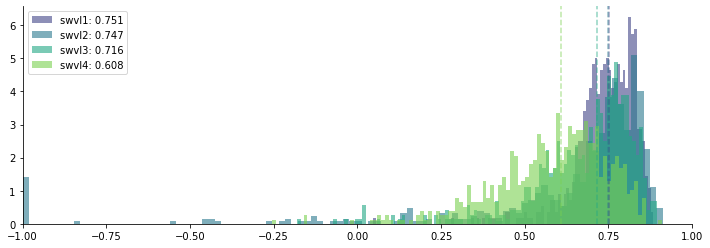

In [35]:
f, ax = plt.subplots(figsize=(12, 4))

colors = sns.color_palette("viridis", n_colors=len(target_vars))
for ix, target_var in enumerate(target_vars):
    errors = all_models_preds[target_var]["errors"]
    nse = errors["NSE"]

    ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"{target_var}: {nse.median().values:.3f}", alpha=0.6, color=colors[ix]);
    ax.axvline(nse.median(), color=colors[ix], ls="--", alpha=0.5)
    

ax.set_xlim(-1, 1)
ax.legend()
sns.despine()

### plot the weights

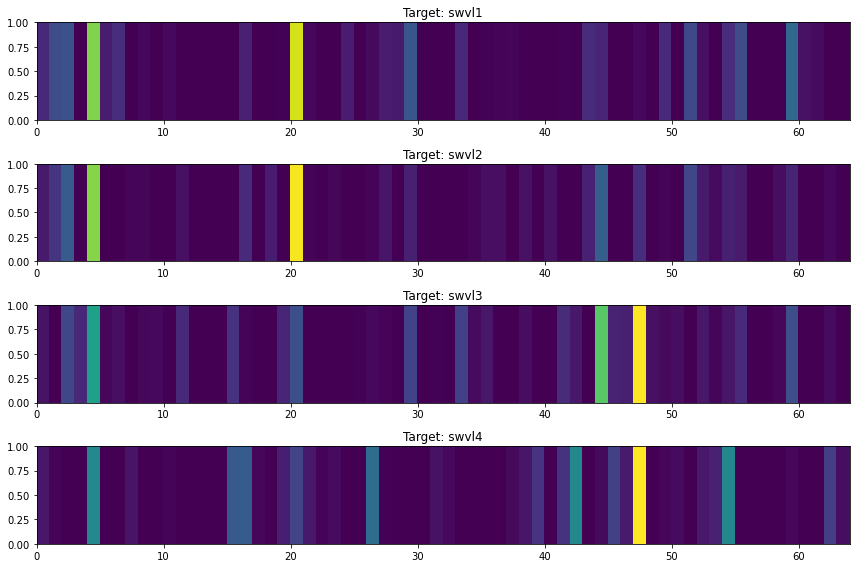

In [38]:
from scripts.cell_state.analysis import get_model_weights, plot_weights

n_plots = len(target_vars)
f, axs = plt.subplots(n_plots, 1, figsize=(12, 2*n_plots))

for ix, target_var in enumerate(target_vars):
    model = all_models_preds[target_var]["model"]
    ax = axs[ix]
    w, b = get_model_weights(model)
    plot_weights(np.abs(w), kwargs={"vmin": 0.0, "vmax": 0.3}, ax=ax, cbar=False)
    ax.set_title(f"Target: {target_var}")
plt.tight_layout()

# What about the spatial performances?

In [39]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [40]:
points = load_latlon_points(Path("/home/tommy/spatio_temporal/data"))

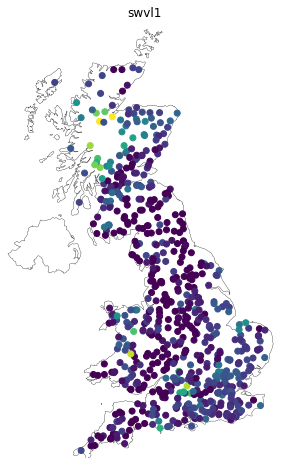

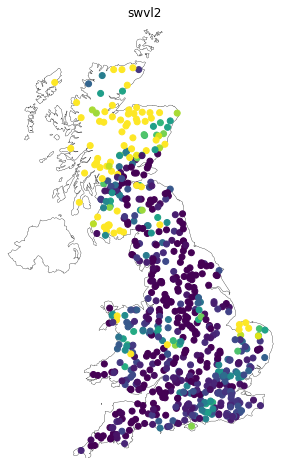

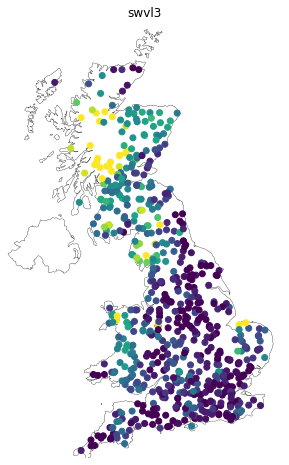

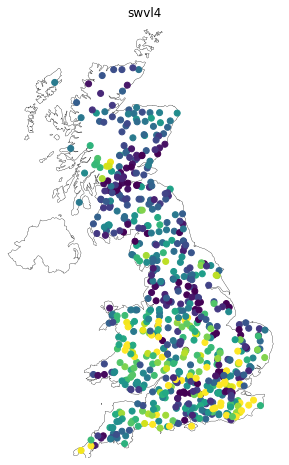

In [50]:
for target_var in target_vars:
    # initialise plotting data
    errors = all_models_preds[target_var]["errors"]
    gdf = gpd.GeoDataFrame(errors["NSE"].to_dataframe().join(points))
    
    # create plot
    ax = initialise_gb_spatial_plot()

    cbar = False
    vmax = 0.8
    vmin = 0.3

    if cbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        gdf.plot("NSE", ax=ax, vmin=vmin, vmax=vmax, cmap="viridis_r", cax=cax, legend=True);
    else:
        gdf.plot("NSE", ax=ax, vmin=vmin, vmax=vmax, cmap="viridis_r")
    
    ax.set_title(f"{target_var}")